In [ ]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
def count_turns(labyrinth):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Rechts, Unten, Links, Oben
    num_turns = 0

    for i in range(1, labyrinth.shape[0] - 1):
        for j in range(1, labyrinth.shape[1] - 1):
            if labyrinth[i, j] == 1:
                valid_neighbors = 0
                for dx, dy in directions:
                    ni, nj = i + dx, j + dy
                    if labyrinth[ni, nj] == 1:
                        valid_neighbors += 1
                if valid_neighbors == 2:  # Zwei gültige Nachbarn bedeuten eine Richtungsänderung
                    num_turns += 1

    return num_turns

In [ ]:

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_bert.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_229999_bert.pt' 


path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_lastunet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_399999_lastunet.pt'


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-28' # 2
config_name = 'config_001_hollowelbo.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_259999_hollowelbo.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [ ]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'TauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 10
cfg.sampler.corrector_entry_time = ScalarFloat(0.2)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = True
#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()


In [4]:
n_samples = 3000 #cfg.data.batch_size 
samples, changes = sampler.sample(model, n_samples)
print(changes)
print(np.mean(changes))
saved_samples = samples

498it [46:00, 20.96s/it]

corrector


499it [46:21, 20.97s/it]

corrector


500it [46:42,  5.60s/it]

[]
nan



/home/pheller/my_python_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pheller/my_python_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
correct_mazes = maze_acc(saved_samples)

Accuracy: From 3000 are 91.5% solvable.
Average path length: 36.2247723132969 and prob 16.099898805909735%
Average wall length: 126.00145719489981 and prob 56.0006476421777%
Average way length: 62.773770491803276 and prob 27.89945355191257%


In [6]:
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = n_samples

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i in dataloader:
    true_dl = i
    c_i = maze_acc(i.cpu().numpy())
    true_dl = true_dl.reshape(cfg.data.batch_size, -1).flatten()

1000 samples generated.
2000 samples generated.
3000 samples generated.
Accuracy: From 3000 are 100.0% solvable.
Average path length: 38.528 and prob 17.123555555555555%
Average wall length: 126.0 and prob 56.0%
Average way length: 60.472 and prob 26.876444444444445%


In [7]:
samples = samples.reshape(cfg.data.batch_size, -1).flatten()
from scipy.stats import wasserstein_distance
print("EMD", wasserstein_distance(samples, true_dl.cpu().numpy()))


# only EMD: 5000
# Unet:
# TauL: 0.02457 40 %
# LBJF: 0.023745777777777866 45%
# MPTauL:

# Hollow:
# LBJF: 0.0011570370370370675 85%
# TauL: 0.005959999999999965 83%
# Analytical: 0.006370370370369915 83.5%

# Hollow Elbo:
# Analytical: 0.002561481481481387 62% # 
# LBJF: # 0.00424 63%
# TauL: 0.0092 63%

# 30: 0.000552592592592438

# 250 bei TauL nochmal oder 500

# ExactSampling: 1500: 85% and EMD  1.22
# LBJF: 93% 1.04

EMD 0.006977777777777638


In [8]:
emd_lbjf = np.array([3.44, 3.38, 2.97, 2.35, 2.12, 1.75, 1.15]) 
emd_anal = np.array([4.75, 3.54, 3.24, 2.92, 2.65, 1.19, 1.16]) 
emd_taul = np.array([63.58, 36.05, 27.64, 17.66, 12.47, 5.96, 2.28]) 

In [9]:
steps = np.array([10, 20, 30, 50, 100, 250, 500] )
acc_lbjf = np.array([60, 75, 80, 82, 84, 85, 88] ) / 100
acc_anal = np.array([55, 75, 78, 82, 83, 83, 85]) / 100
acc_taul = np.array([3, 30, 50, 73, 80, 82, 84]) / 100
rej_rate = np.array([0.1662, 0.0732, 0.0434, 0.0243, 0.0115, 0.003, 0.00084])
#20: 0.07 30: 50: 0.0434, 0.024, 0.0

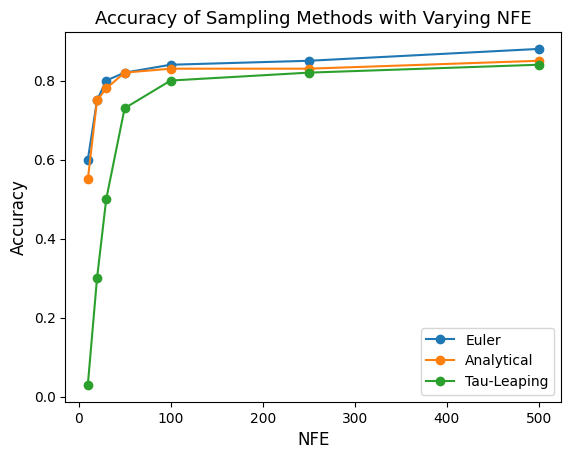

In [10]:
plt.plot(steps, acc_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, acc_anal, label='Analytical', marker='o')
plt.plot(steps, acc_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy of Sampling Methods with Varying NFE', fontsize=13)
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()

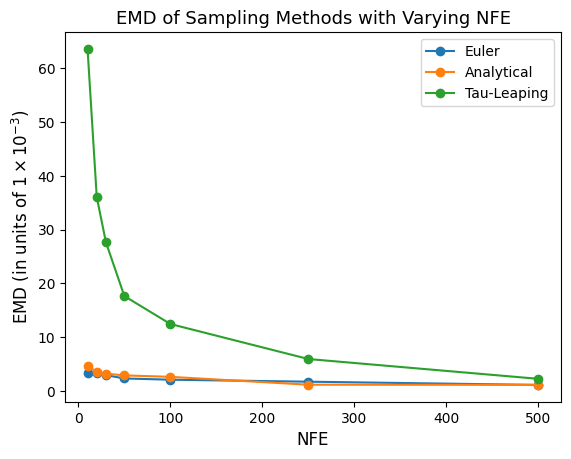

In [11]:
plt.plot(steps, emd_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, emd_anal, label='Analytical', marker='o')
plt.plot(steps, emd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=12)
plt.ylabel('EMD (in units of $1\\times 10^{-3}$)', fontsize=12) 
plt.title('EMD of Sampling Methods with Varying NFE', fontsize=13)
plt.legend()
plt.savefig('emd_plot.png')
plt.show()

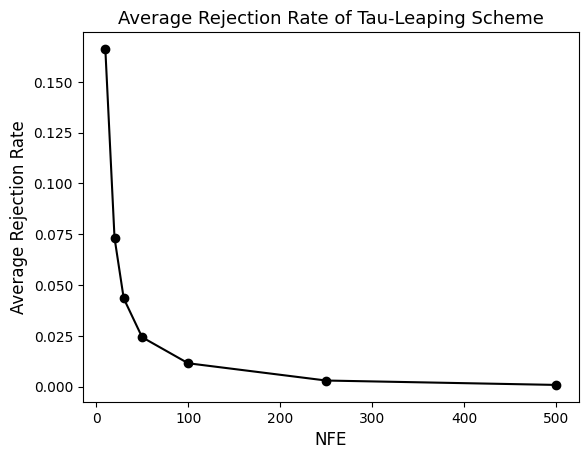

In [12]:
plt.plot(steps, rej_rate, marker='o', color='black')
plt.ylabel('Average Rejection Rate', fontsize=12)
plt.xlabel('NFE', fontsize=12)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=13)
plt.savefig('rej_rate_plot.png')
plt.show()